In [677]:
"""
Loading frameworks
"""

import cv2
import glob
from IPython.display import HTML
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np


In [678]:
"""
Importing test image and initializing the data
"""

straight_lines_image = cv2.imread('./test_images/straight_lines1.jpg')
image_size = (straight_lines_image.shape[1], straight_lines_image.shape[0])

print('Image size = {}'.format(img_size))


Image size = (1280, 720)


In [679]:
"""
Useful functions
"""

def show_image(image, cmap=None):
    """
    Displays an image
    """
    plt.imshow(image, cmap=cmap)
    plt.show()
    

In [680]:
"""
Camera calibration
"""

def draw_chessboard_corners(image, corners, pattern_size, ret):
    """
    Draws chessboard corners over the image and displays a result
    """
    image = cv2.drawChessboardCorners(image, pattern_size, corners, ret)
    show_image(image)

def calibrate_camera(image_names, pattern_size=(9, 6), show_corners=False):
    """
    Calibrates the camera based on images set with chessboards patterns provided.
    Returns camera calibration matrix and distortion coefficients
    """
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
    
    image_size = None
    
    for image_name in image_names:
        image = cv2.imread(image_name)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if image_size is None:
            image_size = gray.shape[::-1]
        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
        
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            if show_corners:
                draw_chessboard_corners(image, corners, pattern_size, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    return mtx, dist

def undistort_image(image, mtx, dist):
    """
    Undistorts an image based on camera calibration matrix and distortion coefficients
    """
    return cv2.undistort(image, mtx, dist, None, mtx)

def show_undistorted_images(image_names, mtx, dist):
    """
    Displays undistorted versions of input images
    """
    for image_name in image_names:
        image = cv2.imread(image_name)
        image = undistort_image(image, mtx, dist)
        show_image(image)
            

In [681]:
"""
Loading camera calibration images and calculating calibration matrix and distortion coefficients
"""

calibration_images = glob.glob('./camera_cal/calibration*.jpg')
calibration_mtx, calibration_dist = calibrate_camera(calibration_images, pattern_size=(9, 6), show_corners=False)


In [682]:
"""
Sobel gradients
"""

def apply_sobel_thresh(image, orient='x', thresh=(0, 255)):
    """
    Applies a Sobel threshold with given orientation x or y
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        orient_num = (1, 0)
    elif orient == 'y':
        orient_num = (0, 1)

    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, orient_num[0], orient_num[1]))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def apply_magnitude_sobel(image, kernel_size=9, thresh=(30, 150)):
    """
    Applies a magnitude Sobel threshold
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    #gray = hls[:, :, 2]
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

def apply_dir_sobel(image, kernel_size=11, thresh=(0.7, 1.3)):
    """
    Applies a direction Sobel threshold
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    #gray = hls[:, :, 2]
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_grad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(abs_grad)
    binary_output[(abs_grad >= thresh[0]) & (abs_grad <= thresh[1])] = 1

    return binary_output

def combine_magnitude_and_dir(image):
    mag_binary = apply_magnitude_sobel(image)
    dir_binary = apply_dir_sobel(image)
    binary_output = np.zeros_like(mag_binary)
    binary_output[(mag_binary == 1) & (dir_binary == 1)] = 1
    return binary_output

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def apply_mask(image, image_size):
    image_width = image_size[0]
    image_height = image_size[1]
    left_bottom = [0, image_height]
    right_bottom = [image_width, image_height]
    left_apex = [image_width * 0.36 , image_height * 0.58]
    right_apex = [image_width * 0.64 , image_height * 0.58]
    center = [image_width / 2, image_height * 0.8]
    left_subbottom = [image_width * 3 / 10, image_height]
    right_subbottom = [image_width * 7 / 10, image_height]
    vertices = np.array([[left_bottom, left_apex, right_apex, right_bottom, right_subbottom, center, left_subbottom]], dtype=np.int32)
    return region_of_interest(image, vertices)

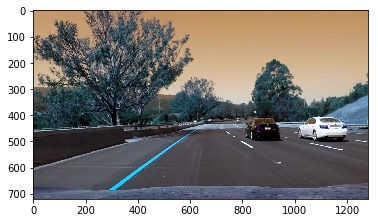

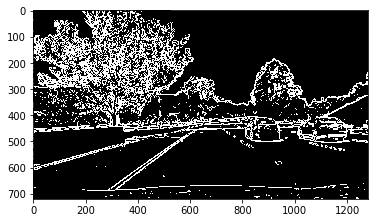

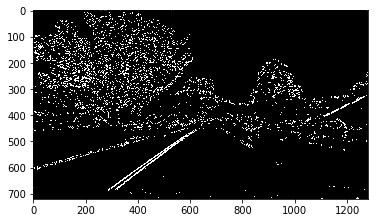

In [683]:

image = cv2.imread('./test_images/test6.jpg')
show_image(image)
binary = apply_magnitude_sobel(image)
show_image(binary, cmap='gray')
binary = combine_magnitude_and_dir(image)
show_image(binary, cmap='gray')



In [684]:
"""
Color thresholding
"""
def apply_hsl_thresh(image, thresh=(150, 255)):
    """
    Applies a threshold for Saturation layer of image in HSL color space
    """
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    s_channel = hls[:, :, 2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output



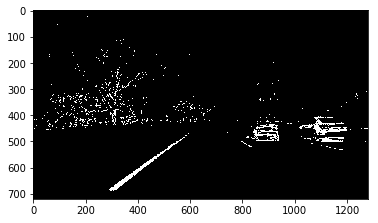

In [685]:

image = cv2.imread('./test_images/test6.jpg')
binary = apply_hsl_thresh(image, thresh=(150, 255))
show_image(binary, cmap='gray')


In [686]:

def combine_sobel_and_hsl(image):
    sobel_binary = combine_magnitude_and_dir(image)
    hsl_binary = apply_hsl_thresh(image)
    binary_output = np.zeros_like(sobel_binary)
    binary_output[(sobel_binary == 1) | (hsl_binary == 1)] = 1
    return binary_output


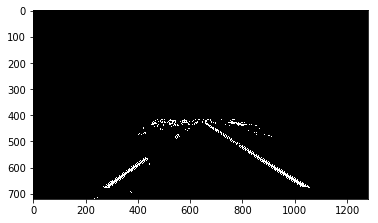

In [687]:

image = cv2.imread('./test_images/straight_lines2.jpg')
binary = combine_sobel_and_hsl(image)
binary = apply_mask(binary, image_size)
show_image(binary, cmap='gray')


In [688]:
"""
Perspective transformation
"""

def get_perspective_transform(src, dst):
    """
    Calculates a matrix of perspective transformation from src to dst points
    """
    return cv2.getPerspectiveTransform(src, dst)

def warp_perspective(image, M, image_size):
    """
    Returns a warped image after applying a perspective transformation
    """
    return cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)


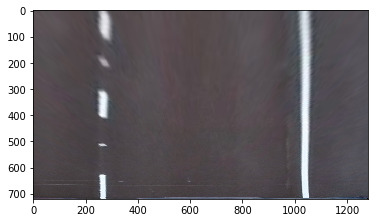

In [689]:
"""
Calculate a perspective matrix
"""

image = cv2.imread('./test_images/straight_lines2.jpg')
# src = np.float32([[602, 446], [682, 446], [1032, 668], [291, 668]])
# src = np.float32([[602, 446], [682, 446], [1048, 682], [275, 682]])
src = np.float32([[589, 454], [695, 454], [1048, 682], [275, 682]])
dst = np.float32([[272, 0], [1037, 0], [1037, 720], [272, 720]])

perspective_M = get_perspective_transform(src, dst)
perspective_Minv = get_perspective_transform(dst, src)

def test_perspective(image, M, image_size):
    image = warp_perspective(image, M, image_size)
    show_image(image)

test_perspective(image, perspective_M, image_size)
    

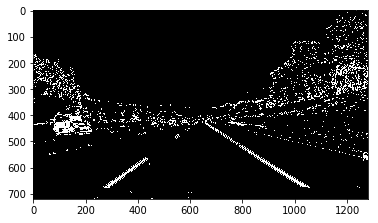

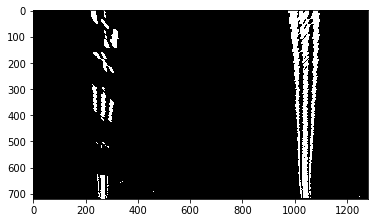

In [690]:

image = cv2.imread('./test_images/straight_lines2.jpg')
# warped = combine_magnitude_and_dir(image)
warped = combine_sobel_and_hsl(image)
show_image(warped, cmap='gray')

warped = warp_perspective(warped, perspective_M, image_size)
show_image(warped, cmap='gray')

In [691]:

def sliding_window_search(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit #, left_lane_inds, right_lane_inds, nonzerox, nonzeroy
    

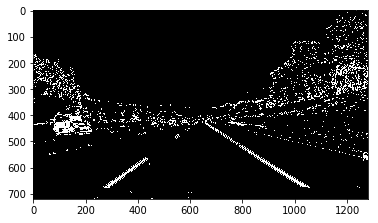

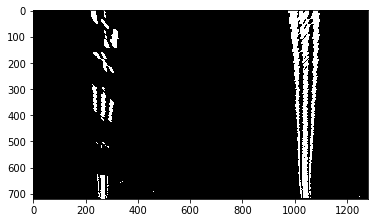

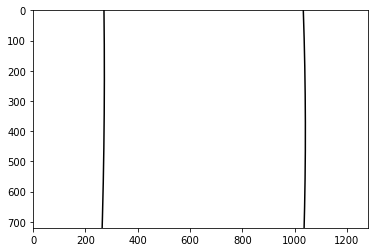

In [692]:

image = cv2.imread('./test_images/straight_lines2.jpg')
warped = combine_sobel_and_hsl(image)
show_image(warped, cmap='gray')

warped = warp_perspective(warped, perspective_M, image_size)
show_image(warped, cmap='gray')

left_fit, right_fit = sliding_window_search(warped)
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.plot(left_fitx, ploty, color='black')
plt.plot(right_fitx, ploty, color='black')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()



In [693]:

def draw_lines(image, warped, image_size, Minv, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(warped, np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (image_size[0], image_size[1])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, new_warp, 0.3, 0)
    return result


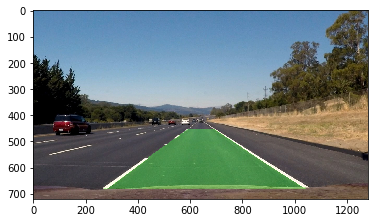

In [694]:

image = cv2.imread('./test_images/straight_lines2.jpg')
#threshed = apply_hsl_thresh(image, thresh=(150, 255))
threshed = combine_sobel_and_hsl(image)
warped = warp_perspective(threshed, perspective_M, image_size)

left_fit, right_fit = sliding_window_search(warped)
ploty = np.linspace(0, image_size[1]-1, image_size[1] )
left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

res = draw_lines(image, warped, image_size, perspective_Minv, left_fitx, right_fitx, ploty)
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
show_image(res)


In [695]:

def full_process_image(image, image_size, mtx, dist, M, Minv):
    undistorted = undistort_image(image, mtx, dist)
    threshed = combine_sobel_and_hsl(undistorted)
    threshed = apply_mask(threshed, image_size)
    warped = warp_perspective(threshed, M, image_size)
    left_fit, right_fit = sliding_window_search(warped)
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    res = draw_lines(undistorted, warped, image_size, Minv, left_fitx, right_fitx, ploty)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    return res
    
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return full_process_image(image, image_size, calibration_mtx, calibration_dist, perspective_M, perspective_Minv)


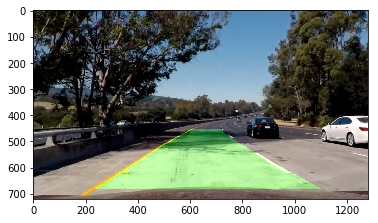

In [696]:

image = cv2.imread('./test_images/test5.jpg')
show_image(full_process_image(image, image_size, calibration_mtx, calibration_dist, perspective_M, perspective_Minv))



In [ ]:

def process_video(video_clip, output_clip_name):
    output_clip = video_clip.fl_image(process_image)
    %time output_clip.write_videofile(output_clip_name, audio=False)



In [662]:

video_clip = VideoFileClip('./project_video.mp4')
output_clip = video_clip.fl_image(process_image)
output_clip_name = './output_videos/project_video_output.mp4'
%time output_clip.write_videofile(output_clip_name, audio=False)


[MoviePy] >>>> Building video ./output_videos/project_video_output.mp4
[MoviePy] Writing video ./output_videos/project_video_output.mp4



100%|█████████▉| 1260/1261 [04:58<00:00,  4.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_output.mp4 

CPU times: user 6min 6s, sys: 4.53 s, total: 6min 10s
Wall time: 4min 59s


In [697]:

video_clip = VideoFileClip('./challenge_video.mp4')
output_clip = video_clip.fl_image(process_image)
output_clip_name = './output_videos/challenge_video_output.mp4'
%time output_clip.write_videofile(output_clip_name, audio=False)


[MoviePy] >>>> Building video ./output_videos/challenge_video_output.mp4
[MoviePy] Writing video ./output_videos/challenge_video_output.mp4



100%|██████████| 485/485 [01:55<00:00,  4.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_video_output.mp4 

CPU times: user 2min 22s, sys: 1.76 s, total: 2min 24s
Wall time: 1min 56s
